In [1]:
# !pip install -r requirements.txt

import pandas as pd
from utils.LabelsDict import tickers
from utils.setup import setup_enviroment

setup_enviroment()

from utils.portfolio import Portfolio
from utils.logger import Logger
log = Logger(__name__)

In [2]:
# No Logger class to reset; handlers are cleared above if needed

# Define tickers list
tickers_list = [
    'GAZP', 'LKOH', 'ROSN',
    'SBER', 'VTBR', 'MOEX',
    'GMKN', 'NLMK', 'RUAL',
    'MTSS', 'RTKM', 'TTLK',
    'MGNT', 'FESH',  #LENT
]

# Recreate the Portfolio instance with the updated code
calc = Portfolio(
    dt_calc='2025-09-30',
    dt_start='2019-03-31',
    stocks_step=8,
    tickers_list=tickers_list
)
calc = calc.log_system_info()

2026-01-10 20:27:19,559:utils.portfolio:INFO: Configuration Parameters
Parameter                                                                                      Value
Calculation Date                                                                          2025-09-30
Start Date                                                                                2019-03-31
Stocks Step                                                                                        8
Tickers Count                                                                                     14
Tickers           GAZP, LKOH, ROSN, SBER, VTBR, MOEX, GMKN, NLMK, RUAL, MTSS, RTKM, TTLK, MGNT, FESH


In [3]:
# 2. Загрузка рыночных данных
calc = (
    calc
    .load_stock_data(
        use_backup_data=True,
        update_backup=False
    )
    .load_multipliers(
        use_backup=True,
        update_backup=False
    )
)

2026-01-10 20:27:19,786:utils.portfolio:INFO: Using stocks backup data from 2019-03-31 up to 2025-09-30
2026-01-10 20:27:20,112:utils.portfolio:INFO: Loaded Stock Data Period
Start Date    End Date
2019-04-01  2025-09-30
2026-01-10 20:27:20,123:utils.portfolio:INFO: Stock Data Missing Values: No missing values found
2026-01-10 20:27:20,130:utils.portfolio:INFO: Using multipliers backup data from 2019-03-31 up to 2025-09-30
2026-01-10 20:27:20,135:utils.portfolio:INFO: Loaded Multipliers Data Period
Start Date    End Date
2019-03-31  2025-09-30
2026-01-10 20:27:20,139:utils.portfolio:INFO: Multipliers Data Missing Values
Column                    Value
EV/EBITDA                28.84%
P/BV                     39.68%
P/E                      13.23%
P/FCF                    40.21%
P/S                      26.19%
Долг, млрд руб           43.65%
Долг/EBITDA              28.84%
Капитализация, млрд руб  12.17%
Чистый долг, млрд руб    12.17%


In [4]:
calc = (
    calc
    .load_macro_data(
        update_inflation=False,
        update_rub_usd=False,
        update_unemployment=False
    )
    .create_portfolio()
    .add_dynamic_features()
    .add_merton_pd()
)

2026-01-10 20:27:20,699:utils.portfolio:INFO: Loaded Unemployment data from backup
2026-01-10 20:27:20,713:utils.portfolio:INFO: Loaded Unemployment Data Period
Start Date    End Date
2019-03-31  2025-09-30
2026-01-10 20:27:20,745:utils.portfolio:INFO: Loaded inflation data from backup
2026-01-10 20:27:20,754:utils.portfolio:INFO: Loaded Inflation Data Period
Start Date    End Date
2019-03-31  2025-09-30
2026-01-10 20:27:20,763:utils.portfolio:INFO: Loaded USD/RUB exchange rate from backup
2026-01-10 20:27:20,783:utils.portfolio:INFO: Loaded USD/RUB Exchange Rate Period
Start Date    End Date
2019-03-31  2025-09-30
2026-01-10 20:27:21,085:utils.portfolio:INFO: Portfolio Missing Values Before Filling
Column                    Value
P/E                      13.22%
Долг, млрд руб           49.52%
Капитализация, млрд руб  12.12%
Чистый долг, млрд руб    12.12%
debt                     31.76%
2026-01-10 20:27:21,201:utils.portfolio:INFO: Portfolio Missing Values After Filling
Column        

Solving Merton equations: 100%|██████████| 23341/23341 [01:36<00:00, 241.21it/s]

2026-01-10 20:28:58,081:utils.portfolio:INFO: Capital cost and capital volatility calculated.
2026-01-10 20:28:58,088:utils.portfolio:INFO: Merton's probabilities of default and distance to default calculated.


2026-01-10 20:29:00,673:utils.plots:INFO: Correlation matrix saved | Path: logs/graphs/corr_matrix.png


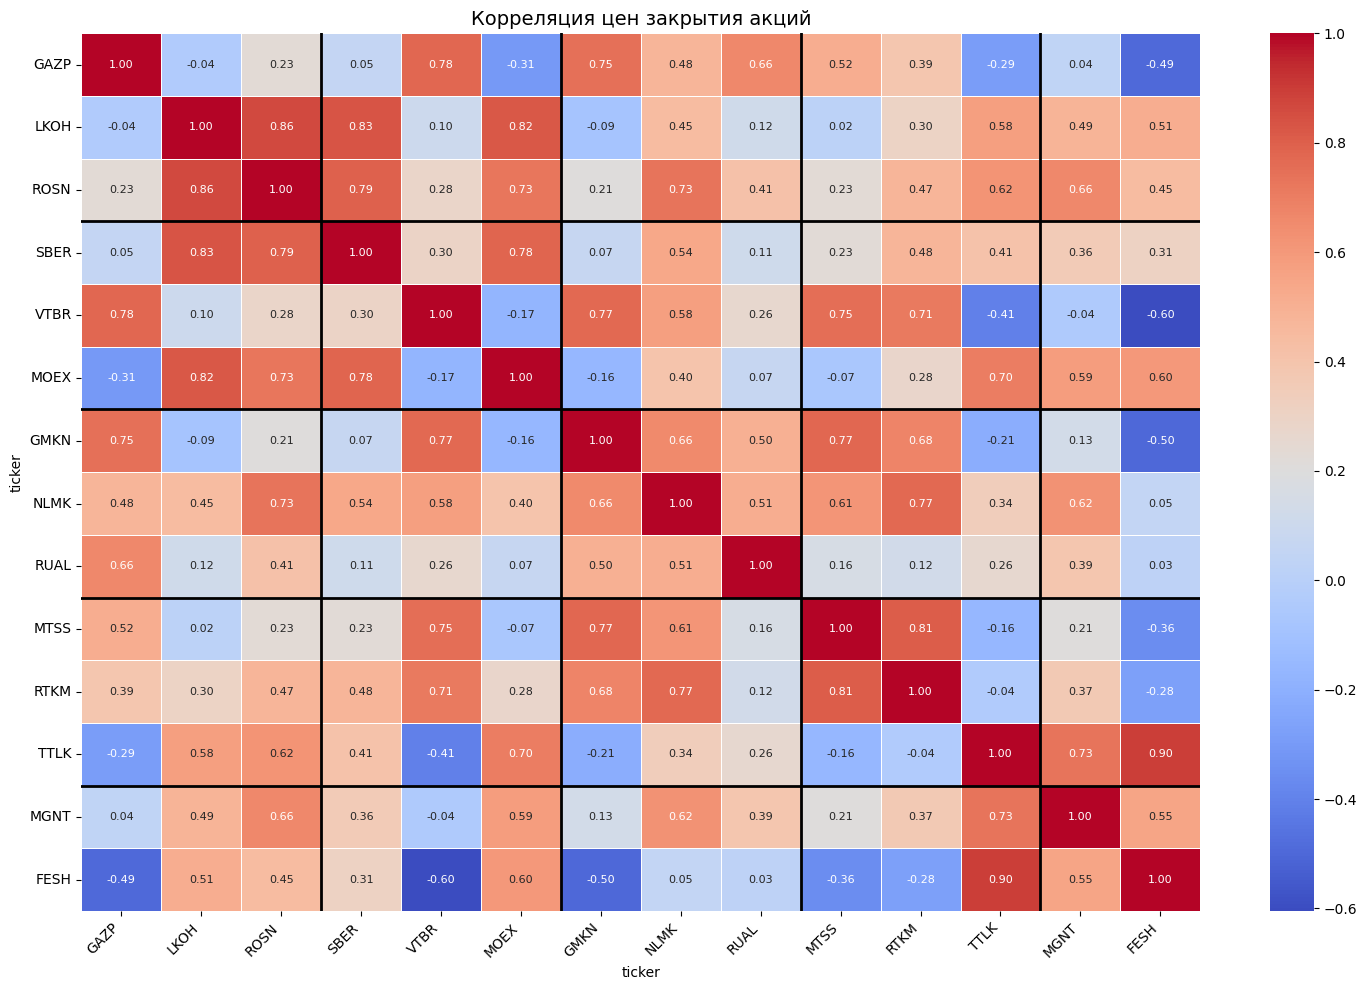

In [5]:
# 2.1 Матрица корреляций и дашборды активов
calc = (
    calc
    .plot_correlation_matrix(custom_order = [                 # нарисовать матрицу корреляций
        'GAZP', 'LKOH', 'ROSN',                               # Нефтегазовая отрасль
        'SBER', 'VTBR', 'MOEX',                               # Финансовый сектор
        'GMKN', 'NLMK', 'RUAL',                               # Металлургия
        'MTSS', 'RTKM', 'TTLK',                               # Телекоммуникации
        'MGNT', 'FESH'                                        # Розничная торговля
    ], verbose=True)
)

# Для детального изучения отдельных компаний (раскомментируйте при необходимости)
# calc.plot_ticker_dashboards(tickers=['GAZP', 'SBER'], verbose=True)

2026-01-10 20:29:01,422:utils.portfolio:INFO: Visualizing Multi-step forecast for 3 months


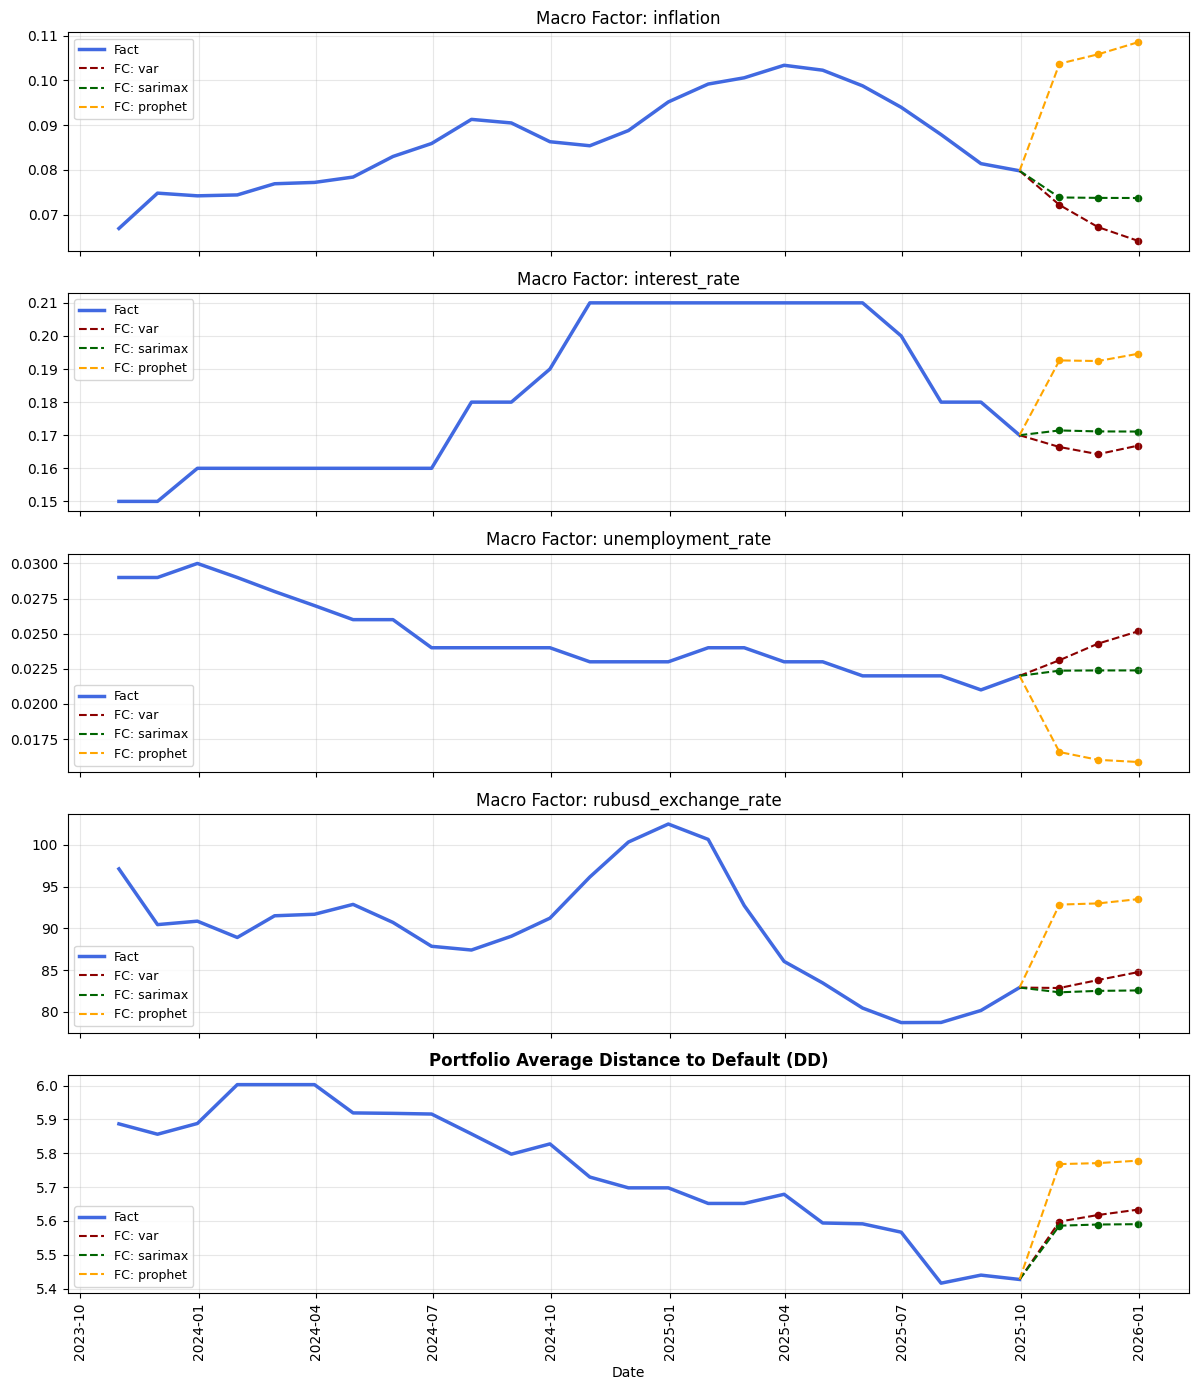

2026-01-10 20:29:53,832:utils.plots:INFO: Macro comparison plot saved: logs/graphs/macro_pd_comparison.png


In [6]:
# 2.2 Прогноз макроэкономических факторов (ВВП, инфляция и др.)
# Позволяет увидеть, какие тренды заложены в прогноз кредитного риска
calc = calc.plot_macro_forecast(
    horizon=3,
    models=['var', 'sarimax', 'prophet'],
    target_col='DD',
    tail=24,
    verbose=True
)

In [7]:
# calc.calc_irf(impulses_responses = {                          # расчитать функции импульсного отклика
#     'inflation': 'PD', 'interest_rate': 'PD',
#     'rubusd_exchange_rate': 'PD', 'unemployment_rate': 'PD'
# }, verbose=True)
# calc.calc_macro_connections()                                 # расчитать регрессию для макропараметров
# calc.log_completion()                                         # вывести в лог сообщение об окончании расчета

2026-01-10 20:29:53,924:utils.portfolio:INFO: Starting strategy backtest for the last 12 months...
2026-01-10 20:29:54,090:utils.portfolio:INFO: Backtesting month: 2024-10
2026-01-10 20:29:54,264:utils.portfolio:INFO: Using predicted PDs (from DD model) for optimization.
2026-01-10 20:29:54,308:utils.portfolio:INFO: Portfolio optimization completed successfully (Lambda=0.99).
2026-01-10 20:29:54,313:utils.portfolio:INFO: Backtesting month: 2024-11
2026-01-10 20:29:54,463:utils.portfolio:INFO: Using predicted PDs (from DD model) for optimization.
2026-01-10 20:29:54,516:utils.portfolio:INFO: Portfolio optimization completed successfully (Lambda=0.99).
2026-01-10 20:29:54,524:utils.portfolio:INFO: Backtesting month: 2024-12
2026-01-10 20:29:54,681:utils.portfolio:INFO: Using predicted PDs (from DD model) for optimization.
2026-01-10 20:29:54,735:utils.portfolio:INFO: Portfolio optimization completed successfully (Lambda=0.99).
2026-01-10 20:29:54,747:utils.portfolio:INFO: Backtesting mon

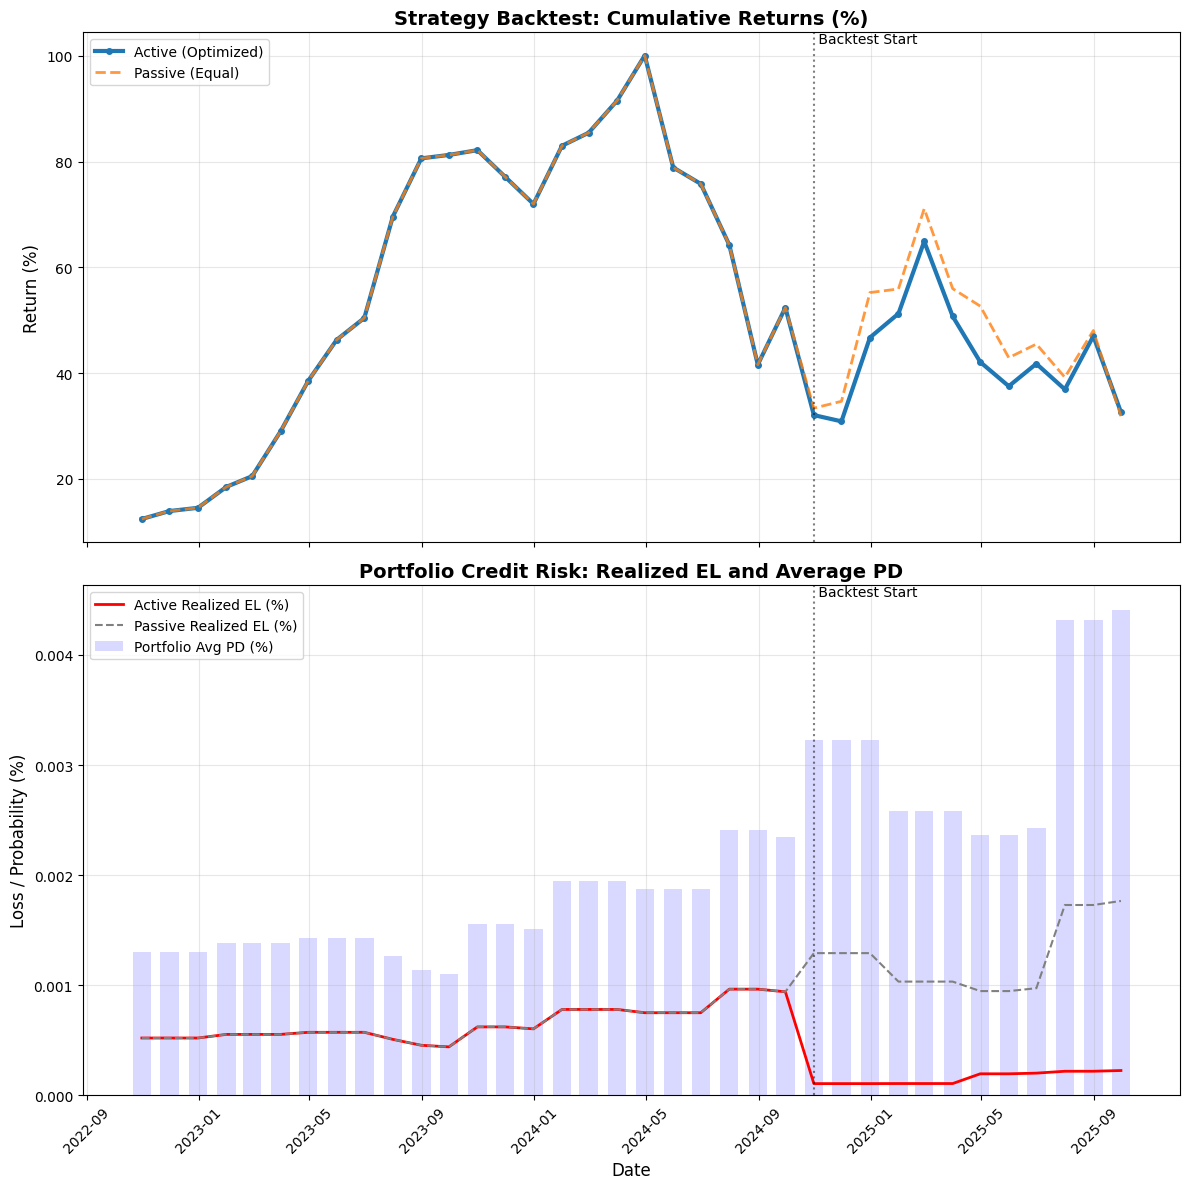

2026-01-10 20:29:59,161:utils.plots:INFO: Strategy comparison plot saved: logs/graphs/strategy_backtest_comparison.png


,Total Return (%),Avg Realized EL (%),Realized Volatility (%)
Active (Optimized),-12.969404,0.000157,27.538984
Passive (Equal),-13.472751,0.001254,29.188236


In [8]:
# 3. Управление портфелем и Бэктест стратегий
# Сравним Активную стратегию (оптимизация по прогнозу DD) и Пассивную (равные веса)
# Показываем последние 36 месяцев истории (из них последние 12 месяцев - активное управление)
calc = (
    calc
    .backtest_portfolio_strategies(n_months=12, lambda_risk=0.99, lgd=0.4, model_type='var')
    .plot_strategy_backtest(tail=36, verbose=True)
)

# Вывод сводной таблицы результатов
display(calc.d['strategy_comparison'])

d:\Study\MSU\6_year\Diploma\masters\masters\utils\plots.py:693: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, x="ticker", y="weight", palette="viridis")


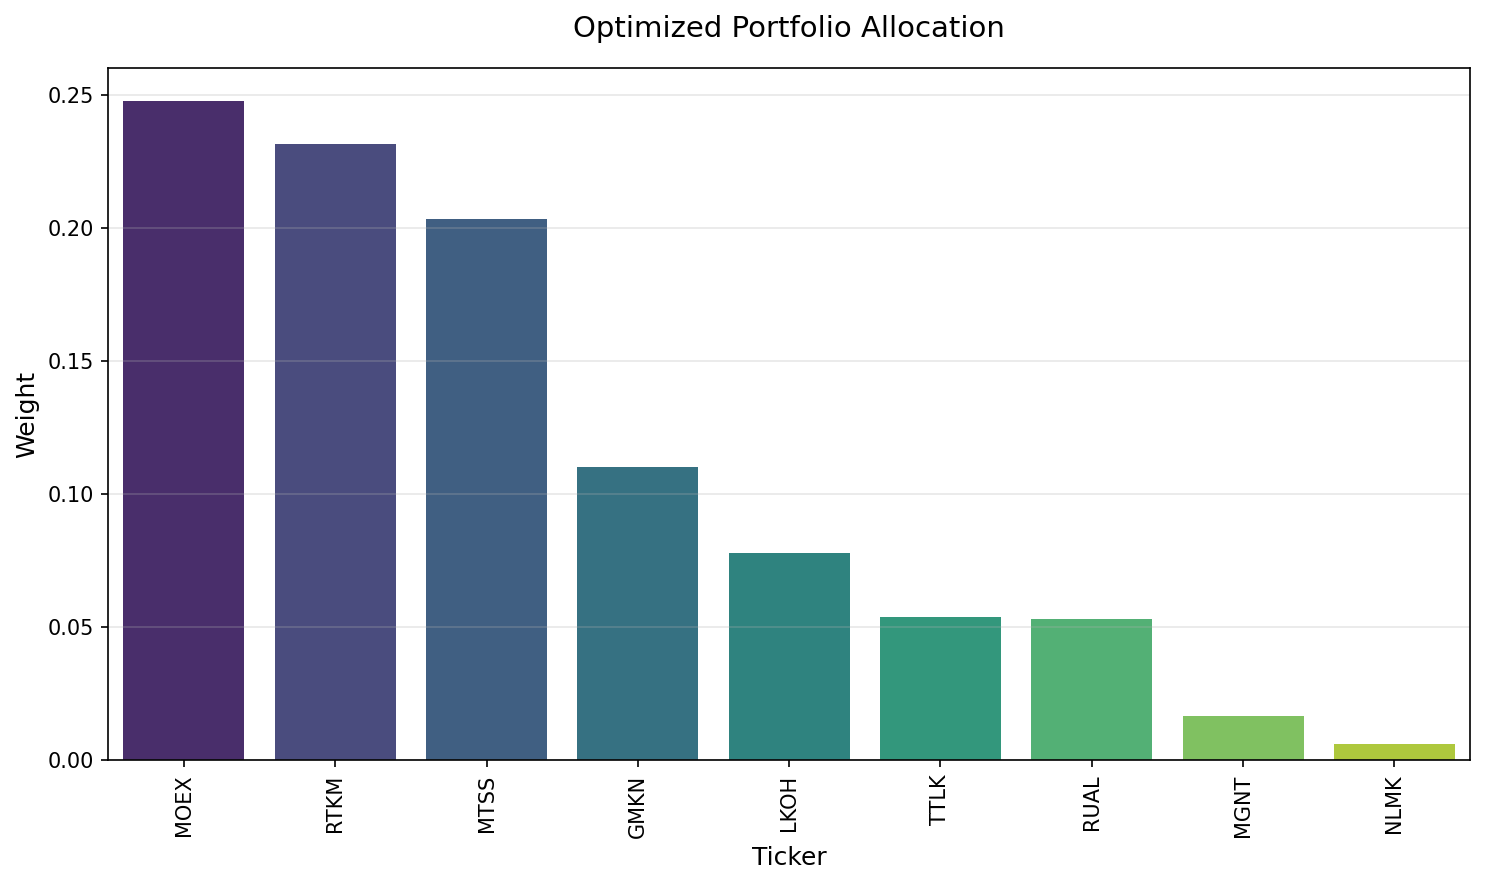

2026-01-10 20:29:59,990:utils.plots:INFO: Portfolio allocation plot saved: logs/graphs/portfolio_allocation.png


In [9]:
# 4. Визуализация структуры портфеля и аллокации активов
calc = calc.plot_portfolio_allocation(figsize=(10, 6), verbose=True)

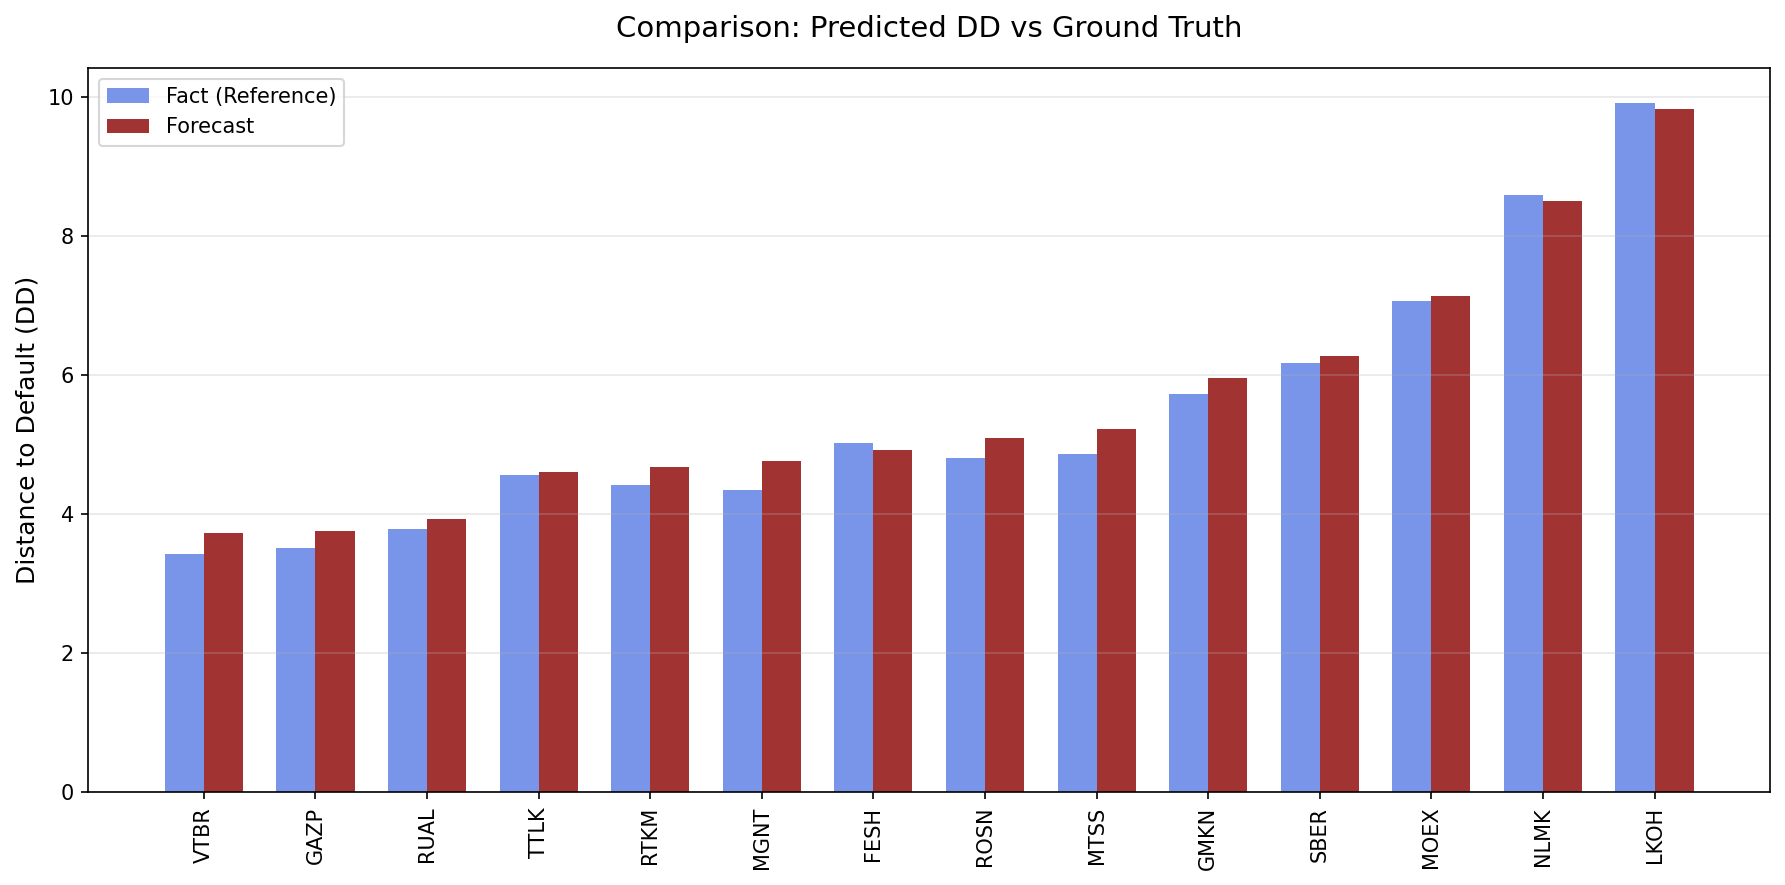

2026-01-10 20:30:00,970:utils.plots:INFO: DD forecast comparison plot saved: logs/graphs/dd_forecast_comparison.png


In [10]:
# 5. Прогноз вероятности дефолта (PD) и дистанции до дефолта (DD)
# Эти графики показывают, как макро-модели видят кредитный риск в ближайшем будущем
calc = (
    calc
    .plot_dd_forecast(figsize=(12, 6), verbose=True)
)